In [1]:
import os #directory
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

In [2]:
os.chdir("./data/")

# Keras Function

In [3]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [4]:
train_Mnist = pd.read_csv("Mnist_train.csv")
test_Mnist = pd.read_csv("Mnist_test.csv")

In [5]:
train_Mnist.shape

(42000, 785)

In [6]:
test_Mnist.shape

(28000, 784)

In [7]:
train_Mnist.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# The labels were given as integers between 0 and 9. We need to convert these to one-hot encoding, i.e. a 10x1 array with one 1 and nine 0:s, with the position of the 1 showing us the value. See the example, with the position of the 1 showing the correct value for the digit in the graph above.

In [11]:
X = np.array(train_Mnist.iloc[:, 1:])
y = to_categorical(np.array(train_Mnist.iloc[:, 0]))

#Here we split validation data to optimiza classifier during training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

In [12]:
y[1:5]

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

Text(0.5,1,'28x28')

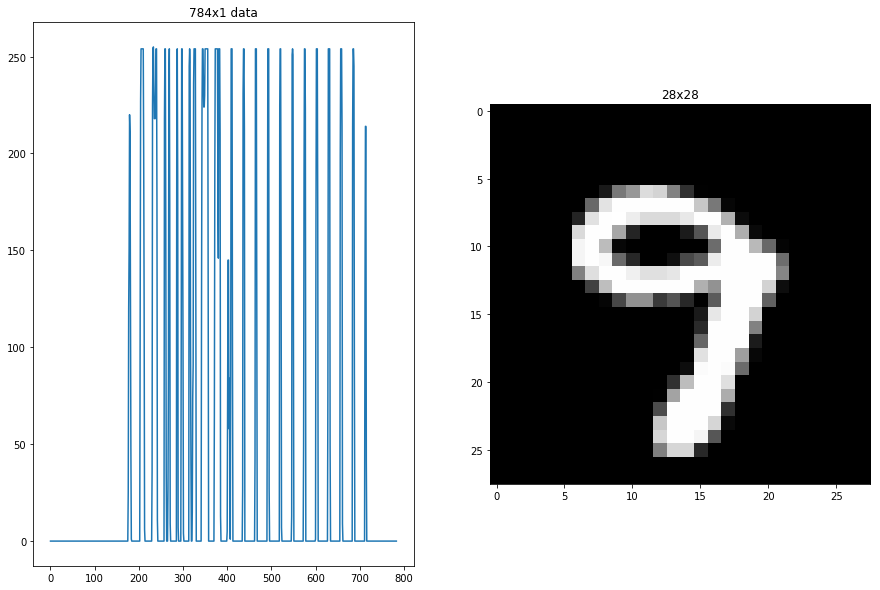

In [13]:
fig,ax = plt.subplots(1,2,figsize = (15,10))
ax[0].plot(X_train[2])
ax[0].set_title('784x1 data')
ax[1].imshow(X_train[2].reshape(28,28),cmap = 'gray')
ax[1].set_title('28x28')

In [14]:
X_train.shape

(33600, 784)

In [15]:
X_val.shape

(8400, 784)

In [16]:
Mnist_train = X_train.reshape(-1,28,28,1)
Mnist_val = X_val.reshape(-1,28,28,1)

In [17]:
Mnist_train.shape

(33600, 28, 28, 1)

# Normalization of the Image- Data b/w 0 and 1 make net converge Faster

In [19]:
Mnist_train = Mnist_train.astype("float32")/255
Mnist_val = Mnist_val.astype("float32")/255

# Keras- Sequential API to Train the Model

In [22]:
mnist_1 = Sequential()
mnist_1.add(Conv2D(filters = 16,kernel_size = (3,3),activation = 'relu',input_shape = (28,28,1)))
mnist_1.add(BatchNormalization())
mnist_1.add(Conv2D(filters = 16,kernel_size = (3,3),activation = 'relu'))
mnist_1.add(BatchNormalization())
mnist_1.add(MaxPool2D(strides = (2,2)))
mnist_1.add(Dropout(0.25))

mnist_1.add(Conv2D(filters = 32,kernel_size = (3,3),activation = 'relu'))
mnist_1.add(Conv2D(filters = 32,kernel_size = (3,3),activation= 'relu'))
mnist_1.add(BatchNormalization())
mnist_1.add(MaxPool2D(strides=(2,2)))
mnist_1.add(Dropout(0.20))

mnist_1.add(Flatten())
mnist_1.add(Dense(512,activation = 'relu'))
mnist_1.add(Dropout(0.25))
mnist_1.add(Dense(1024,activation = 'relu'))
mnist_1.add(Dropout(0.5))
mnist_1.add(Dense(10,activation = 'softmax'))
mnist_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 16)        2320      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 32)        4640      
__________

# Data Augmentation

In [23]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [24]:
mnist_1.compile(loss = 'categorical_crossentropy',optimizer = Adam(lr = 1e-4),metrics = ['accuracy'])

In [25]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [26]:
hsit  = mnist_1.fit_generator(datagen.flow(Mnist_train,y_train,batch_size = 32),
                              steps_per_epoch = 250,
                              epochs = 40,
                              verbose = 2,
                              validation_data = (Mnist_val[:400,:],y_val[:400,:]),
                              callbacks = [annealer])
                              

Epoch 1/40
 - 52s - loss: 0.9194 - acc: 0.7007 - val_loss: 0.2318 - val_acc: 0.9225
Epoch 2/40
 - 50s - loss: 0.3547 - acc: 0.8899 - val_loss: 0.1379 - val_acc: 0.9550
Epoch 3/40
 - 50s - loss: 0.2460 - acc: 0.9246 - val_loss: 0.0725 - val_acc: 0.9825
Epoch 4/40
 - 49s - loss: 0.1917 - acc: 0.9394 - val_loss: 0.0838 - val_acc: 0.9750
Epoch 5/40
 - 49s - loss: 0.1790 - acc: 0.9427 - val_loss: 0.0867 - val_acc: 0.9750
Epoch 6/40
 - 50s - loss: 0.1581 - acc: 0.9501 - val_loss: 0.0529 - val_acc: 0.9850
Epoch 7/40
 - 50s - loss: 0.1453 - acc: 0.9556 - val_loss: 0.0668 - val_acc: 0.9875
Epoch 8/40
 - 49s - loss: 0.1200 - acc: 0.9647 - val_loss: 0.0473 - val_acc: 0.9850
Epoch 9/40
 - 50s - loss: 0.1198 - acc: 0.9647 - val_loss: 0.0360 - val_acc: 0.9925
Epoch 10/40
 - 50s - loss: 0.1194 - acc: 0.9637 - val_loss: 0.0268 - val_acc: 0.9925
Epoch 11/40
 - 50s - loss: 0.0963 - acc: 0.9711 - val_loss: 0.0324 - val_acc: 0.9925
Epoch 12/40
 - 49s - loss: 0.0993 - acc: 0.9705 - val_loss: 0.0387 - val_a

# Model Evaluation Using Complete Dataset

In [63]:
loss,acc = mnist_1.evaluate(Mnist_val,y_val,verbose =0)

In [69]:
print("Final Loss: {0:.4f},Final accuracy:{1:.4f}".format(loss,acc))

Final Loss: 0.0279,Final accuracy:0.9919


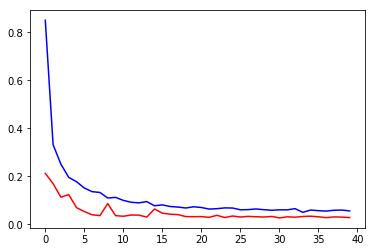

In [72]:
plt.plot(hsit.history['loss'],color = 'b')
plt.plot(hsit.history['val_loss'],color = 'r')
plt.show()

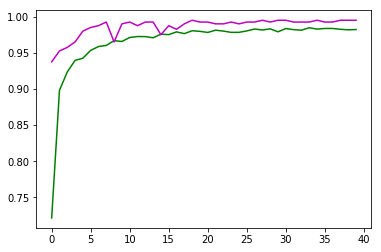

In [75]:
plt.plot(hsit.history["acc"],color = 'g')
plt.plot(hsit.history['val_acc'],color = 'm')
plt.show()

In [83]:
y_hat = mnist_1.predict(Mnist_val)
y_pred = np.argmax(y_hat,axis = 1)
y_true = np.argmax(y_val,axis = 1)
cm = confusion_matrix(y_true,y_pred)
print(cm)

[[818   0   0   0   0   0   4   0   3   0]
 [  0 916   0   1   0   0   1   6   1   0]
 [  1   0 801   1   0   0   0   3   1   1]
 [  1   0   3 854   0   3   0   1   3   1]
 [  0   0   0   0 817   0   0   1   0   5]
 [  0   0   1   1   0 803   1   0   0   0]
 [  2   0   0   1   1   1 819   0   0   0]
 [  0   2   6   0   1   0   0 877   0   1]
 [  0   0   1   0   0   0   0   0 828   1]
 [  2   0   0   0   1   0   0   0   4 799]]


# Calculating Precision,Recall and F- Measure

In [84]:
# Precision = TP/(TP + FP)
# Recall = TP/(TP + FN)
# F1 Measure = (1/ (1/P + 1/R))


In [94]:
TP = np.diag(cm)
FP = np.sum(cm,axis= 0)-TP
FN = np.sum(cm,axis = 1)

In [95]:
Precision = TP/(TP + FP)
Recall = TP/(TP + FN)
f1_measure = 1/((1/Precision)+ (1/Recall))

In [96]:
Precision

array([0.99271845, 0.99782135, 0.9864532 , 0.995338  , 0.99634146,
       0.99504337, 0.99272727, 0.98761261, 0.98571429, 0.98886139])

In [97]:
Recall

array([0.49786975, 0.49755568, 0.49782474, 0.49651163, 0.49817073,
       0.49906774, 0.49847839, 0.49716553, 0.49939686, 0.49781931])

In [99]:
f1_measure

array([0.33157681, 0.33200435, 0.33085502, 0.33126455, 0.33211382,
       0.33236755, 0.33184765, 0.33069382, 0.33146517, 0.33112308])

# Test Dataset

In [101]:
mnist_test = pd.read_csv("Mnist_test.csv")
mnist_test.shape

(28000, 784)

In [103]:
mnist_test = np.array(mnist_test.astype("float32"))
x_test = mnist_test.reshape(-1,28,28,1)/255

In [104]:
y_hat = mnist_1.predict(x_test,batch_size = 32)


In [105]:
y_pred = np.argmax(y_hat,axis = 1)

In [116]:
results = pd.Series(y_pred,name = 'Label')
submission = pd.concat([pd.Series(range(1,28001),name = 'ImageId'),results],axis = 1)
submission.to_csv("CNN_Mnist_Test.csv",index = False)